# <span style="color:orange;">Adaptive Otsu Thresholding Adventure</span>

# Step 1: Import necessary libraries

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.util import img_as_ubyte
from tqdm import tqdm
from joblib import Parallel, delayed

In [28]:
# Set plotting style and parameters
sns.set_style('whitegrid')
plt.rcParams.update({   # Runtime Configuration Parameters
    'figure.figsize': (12, 8),
    'figure.dpi': 100,  # Sharper images for display
    'font.size': 10     # Consistent font size
})

In [29]:
# Informative startup message
print("✅ Libraries imported successfully (numpy, matplotlib, skimage, scipy).")
print("🔍 Starting Adaptive Otsu thresholding demo (for grayscale image segmentation)...")

✅ Libraries imported successfully (numpy, matplotlib, skimage, scipy).
🔍 Starting Adaptive Otsu thresholding demo (for grayscale image segmentation)...


# Step 2: Load and resize image (with detailed checks)

In [30]:
# Load sample image and check basic properties
original_img = data.camera()
h_original, w_original = original_img.shape
dtype_original = original_img.dtype
intensity_range_original = (original_img.min(), original_img.max())

In [31]:
# Print COMPLETE original image info (not just shape)
print(f"\n📊 Original Image Properties:")
print(f"   - Dimensions: {h_original}px (height) × {w_original}px (width)")
print(f"   - Data type: {dtype_original}")
print(f"   - Intensity range (black → white): {intensity_range_original[0]} → {intensity_range_original[1]}")
print(f"   - Total pixels: {h_original * w_original:,}")  # Add commas for readability


📊 Original Image Properties:
   - Dimensions: 512px (height) × 512px (width)
   - Data type: uint8
   - Intensity range (black → white): 0 → 255
   - Total pixels: 262,144


In [32]:
# Resize logic (preserve aspect ratio, cap at 256px max dimension)
max_size = 256
scale = min(max_size / h_original, max_size / w_original)  # Scale to fit max_size
h_resized, w_resized = int(h_original * scale), int(w_original * scale)
# Resize and convert to 8-bit (ubyte) for consistency
resized_img = resize(
    original_img, 
    (h_resized, w_resized), 
    anti_aliasing=True,  # Reduce jagged edges
    preserve_range=True  # Keep intensity values (0-255)
)
resized_img = resized_img / 255.0  # Normalize to 0-1 range first
resized_img = img_as_ubyte(resized_img)  # Convert to 8-bit (0-255)
# Calculate intensity range **after** conversion (now it's defined)
intensity_range_resized = (resized_img.min(), resized_img.max())
# Print resized image info (now intensity_range_resized exists)
print(f"\n📏 Resized Image Properties (aspect ratio preserved):")
print(f"   - Dimensions: {h_resized}px (height) × {w_resized}px (width)")
print(f"   - Scaling factor applied: {scale:.2f}x")
print(f"   - Intensity range (after resizing): {intensity_range_resized[0]} → {intensity_range_resized[1]}")
print(f"   - Total pixels: {h_resized * w_resized:,}")


📏 Resized Image Properties (aspect ratio preserved):
   - Dimensions: 256px (height) × 256px (width)
   - Scaling factor applied: 0.50x
   - Intensity range (after resizing): 2 → 255
   - Total pixels: 65,536


# Step 3: Display original vs resized

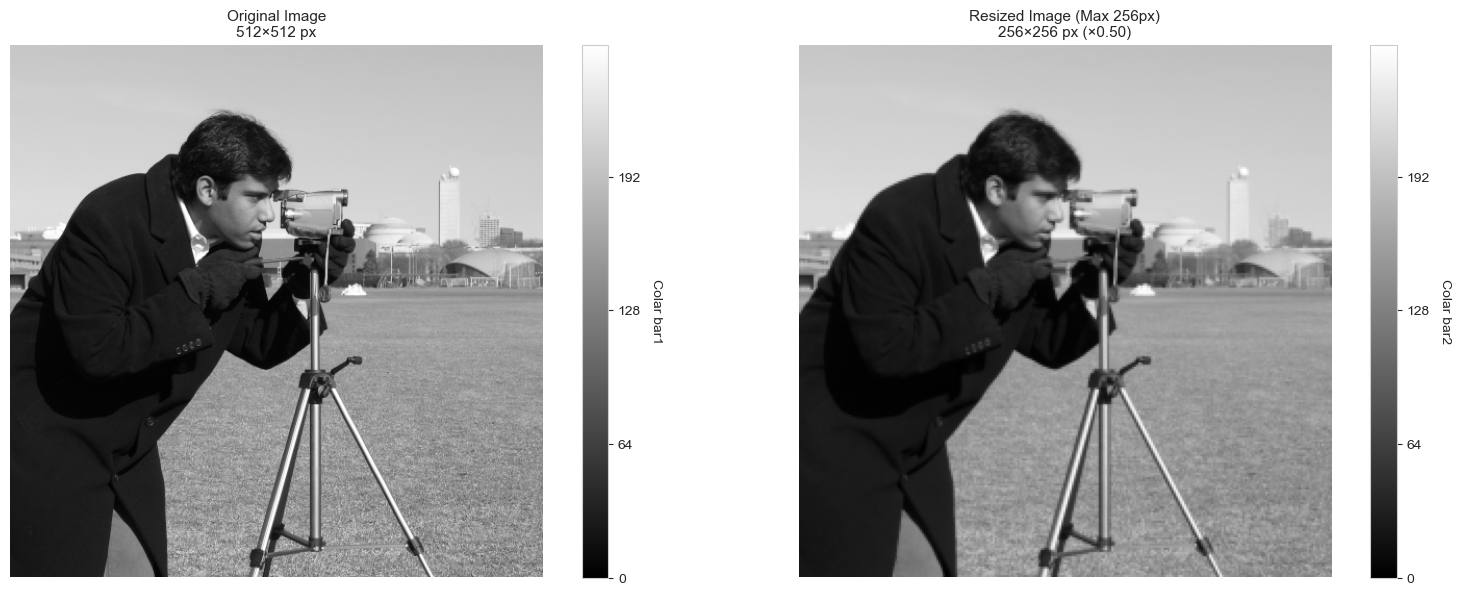

In [33]:
# Add pixel dimensions to titles for clarity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original image (with dimensions in title)
im = axes[0].imshow(original_img, cmap='gray')
axes[0].set_title(f'Original Image\n{h_original}×{w_original} px', fontsize=11)
axes[0].axis('off')

# Add colorbar to map numbers to visual colors
cbar0 = plt.colorbar(im, ax=axes[0], ticks = [0, 64, 128, 192, 256])
cbar0.set_label('Colar bar1', rotation=270, labelpad=15)  # Rotate label for readability


# Resized image (with scaling factor in title)
axes[1].imshow(resized_img, cmap='gray')
axes[1].set_title(f'Resized Image (Max 256px)\n{h_resized}×{w_resized} px (×{scale:.2f})', fontsize=11)
axes[1].axis('off')

# Add colorbar to map numbers to visual colors
cbar1 = plt.colorbar(im, ax=axes[1], ticks = [0, 64, 128, 192, 256])
cbar1.set_label('Colar bar2', rotation=270, labelpad=15)  # Rotate label for readability

plt.tight_layout()
plt.show()

# 3. 全局Otsu阈值处理

In [34]:
global_thresh = threshold_otsu(resized_img)
binary_global = resized_img > global_thresh

# 计算前景像素统计
foreground_pixels = np.sum(binary_global)
total_pixels = binary_global.size
foreground_percentage = (foreground_pixels / total_pixels) * 100

print(f"全局Otsu阈值: {global_thresh}")
print(f"前景像素数: {foreground_pixels}")
print(f"前景百分比: {foreground_percentage:.2f}%")

全局Otsu阈值: 102
前景像素数: 44625
前景百分比: 68.09%


# 4. 创建自适应Otsu函数

In [35]:
def extract_local(i, j, padded_image, image, window_size):
    # 提取局部窗口
    window = padded_image[i:i+window_size, j:j+window_size]
    
    # 计算局部Otsu阈值
    local_thresh = threshold_otsu(window)
    
    return image[i, j] > local_thresh, local_thresh

def adaptive_otsu(image, window_size):
    """
    应用自适应Otsu阈值处理
    
    参数:
    image: 输入图像
    window_size: 滑动窗口大小
    
    返回:
    binary: 二值化结果
    threshold_map: 局部阈值映射
    """
    # 确保窗口大小为奇数
    if window_size % 2 == 0:
        window_size += 1
    
    # 初始化输出数组
    binary = np.zeros_like(image, dtype=bool)
    threshold_map = np.zeros_like(image, dtype=float)
    
    # 计算填充大小
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')
    
    m, n = image.shape
    
    # 构建任务列表
    tasks = [(i, j) for i in range(m) for j in range(n)]
    
    # 并行处理
    results = Parallel(n_jobs=-1, backend='loky', batch_size=1024)(
        delayed(extract_local)(i, j, padded_image, image, window_size) 
        for i, j in tqdm(tasks, total=m * n)
    )
    
    # 收集结果
    for idx, (i, j) in enumerate(tasks):
        binary[i, j], threshold_map[i, j] = results[idx]
    
    return binary, threshold_map

# 应用自适应Otsu处理 (15x15窗口)
print("正在计算15x15自适应Otsu阈值...")
binary_adaptive_15, threshold_map_15 = adaptive_otsu(resized_img, 15)

# 应用自适应Otsu处理 (35x35窗口)
print("正在计算35x35自适应Otsu阈值...")
binary_adaptive_35, threshold_map_35 = adaptive_otsu(resized_img, 35)

正在计算15x15自适应Otsu阈值...


100%|██████████| 65536/65536 [00:00<00:00, 103242.27it/s]


正在计算35x35自适应Otsu阈值...


100%|██████████| 65536/65536 [00:00<00:00, 101423.59it/s]


# 5. 可视化比较结果

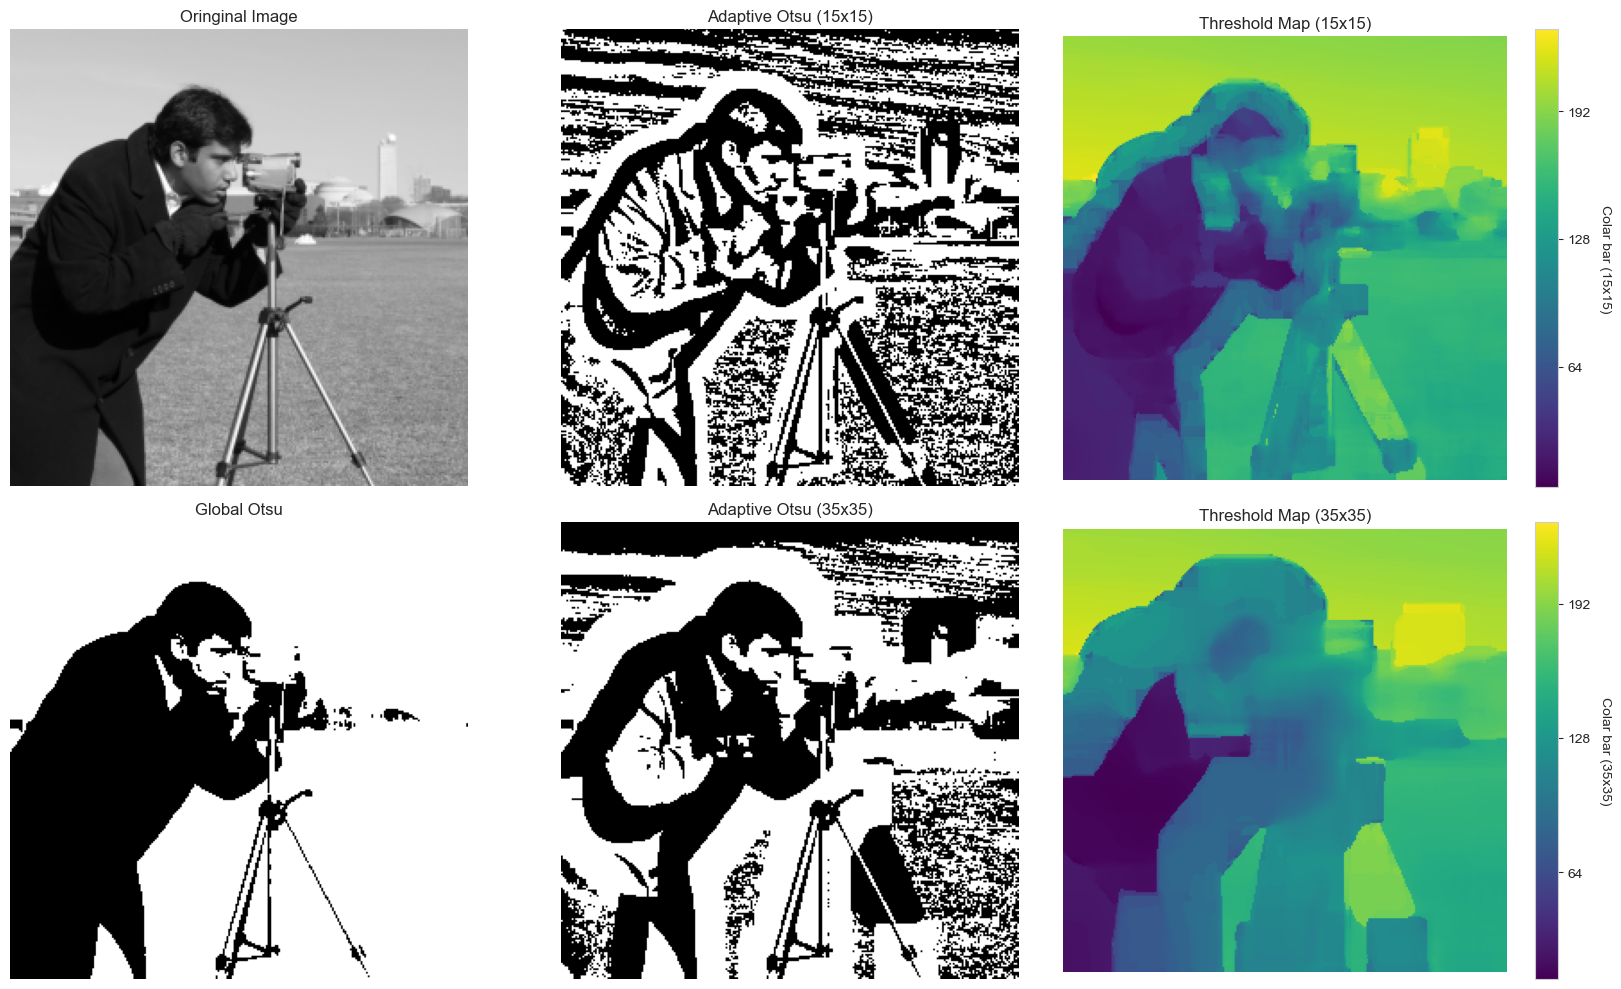

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

# 原始图像
axes[0, 0].imshow(resized_img, cmap='gray')
axes[0, 0].set_title('Oringinal Image')
axes[0, 0].axis('off')

# 全局Otsu
axes[1, 0].imshow(binary_global, cmap='gray')
axes[1, 0].set_title('Global Otsu')
axes[1, 0].axis('off')

# 自适应Otsu 15x15
axes[0, 1].imshow(binary_adaptive_15, cmap='gray')
axes[0, 1].set_title('Adaptive Otsu (15x15)')
axes[0, 1].axis('off')

# 阈值映射 15x15
im = axes[0, 2].imshow(threshold_map_15, cmap='viridis')
axes[0, 2].set_title('Threshold Map (15x15)')
axes[0, 2].axis('off')
cbar0 = plt.colorbar(im, ax=axes[0, 2], ticks = [0, 64, 128, 192, 256])
cbar0.set_label('Colar bar (15x15)', rotation=270, labelpad=15)  # Rotate label for readability

# 自适应Otsu 35x35
axes[1, 1].imshow(binary_adaptive_35, cmap='gray')
axes[1, 1].set_title('Adaptive Otsu (35x35)')
axes[1, 1].axis('off')

# 阈值映射 35x35
im = axes[1, 2].imshow(threshold_map_35, cmap='viridis')
axes[1, 2].set_title('Threshold Map (35x35)')
axes[1, 2].axis('off')
cbar0 = plt.colorbar(im, ax=axes[1, 2], ticks = [0, 64, 128, 192, 256])
cbar0.set_label('Colar bar (35x35)', rotation=270, labelpad=15)  # Rotate label for readability

plt.tight_layout()
plt.show()

# 6. 尝试不同的colormap


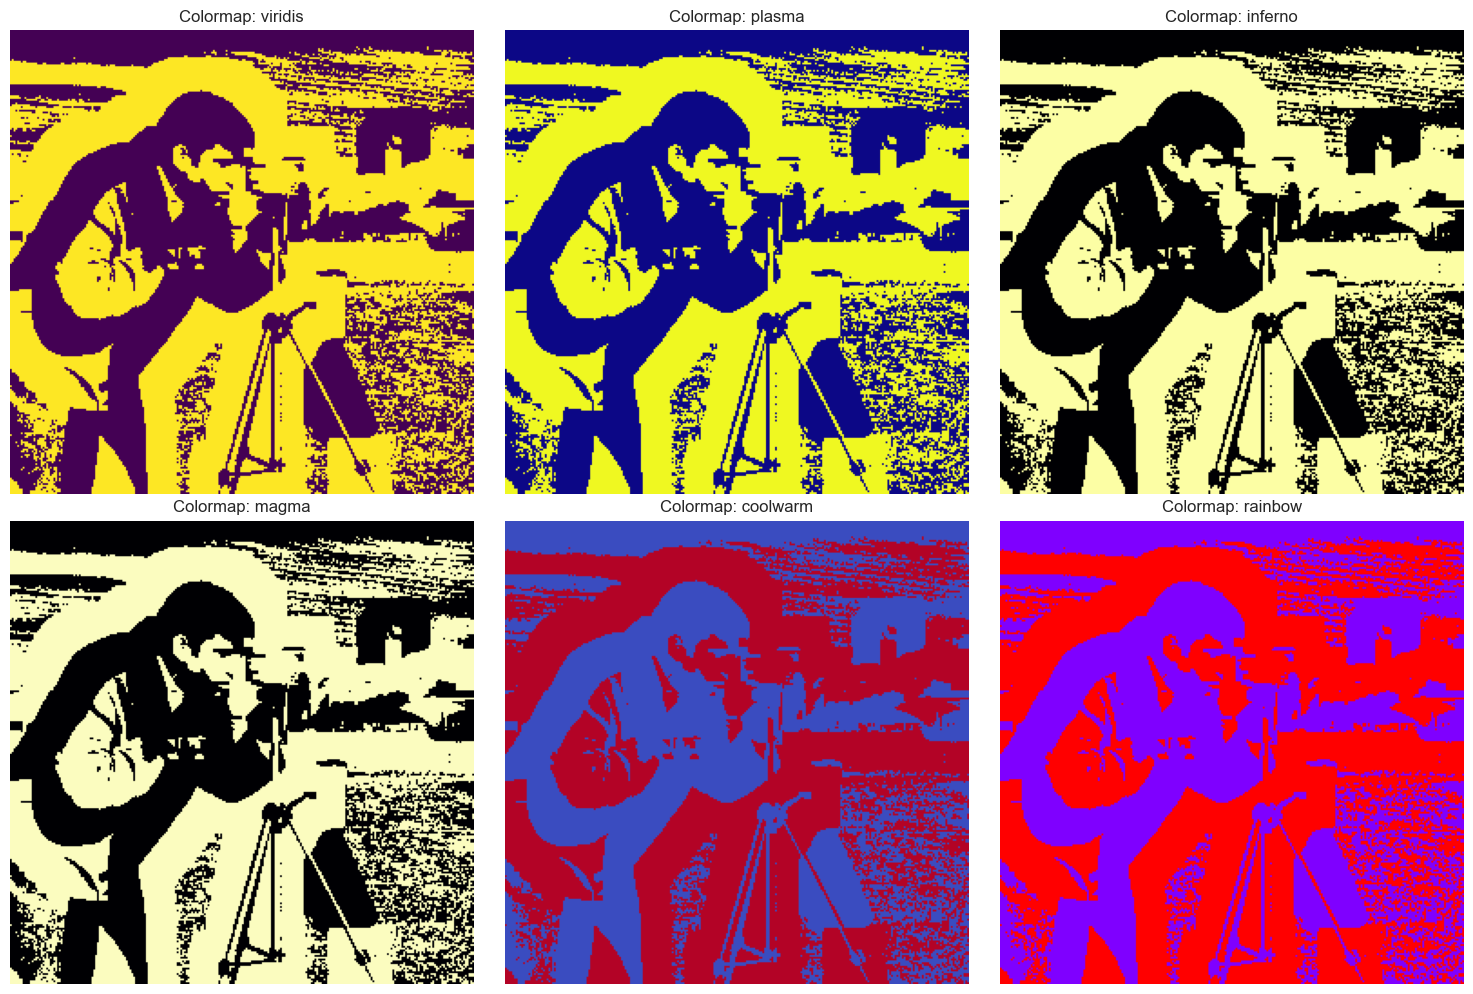

In [37]:
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'coolwarm', 'rainbow']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, cmap in enumerate(colormaps):
    axes[i].imshow(binary_adaptive_35, cmap=cmap)
    axes[i].set_title(f'Colormap: {cmap}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 7. 打印详细指标

In [38]:
print("-" * 50)
print("图像处理指标汇总")
print("-" * 50)
print(f"原始图像尺寸: {original_img.shape}")
print(f"调整后图像尺寸: {resized_img.shape}")
print(f"全局Otsu阈值: {global_thresh}")
print(f"前景像素数: {foreground_pixels} / {total_pixels}")
print(f"前景百分比: {foreground_percentage:.2f}%")
print("-" * 50)

# 8. 窗口大小影响分析
print("窗口大小影响分析:")
print("  - 小窗口(15x15): 能捕捉更多细节但可能引入噪声")
print("  - 大窗口(35x35): 结果更平滑但可能丢失细小特征")
print("  - 选择合适的窗口大小取决于具体应用和图像特性")

--------------------------------------------------
图像处理指标汇总
--------------------------------------------------
原始图像尺寸: (512, 512)
调整后图像尺寸: (256, 256)
全局Otsu阈值: 102
前景像素数: 44625 / 65536
前景百分比: 68.09%
--------------------------------------------------
窗口大小影响分析:
  - 小窗口(15x15): 能捕捉更多细节但可能引入噪声
  - 大窗口(35x35): 结果更平滑但可能丢失细小特征
  - 选择合适的窗口大小取决于具体应用和图像特性


# 自适应Otsu阈值分割方法学习心得

通过实现自适应Otsu阈值分割算法，我深入理解了局部阈值处理在图像分割中的重要性。与全局Otsu方法相比，自适应方法通过滑动窗口计算局部阈值，能够更好地处理光照不均的图像。

## 关键学习点

1. **窗口大小选择的重要性**：
   - 小窗口(15×15)：保留更多细节但对噪声敏感
   - 大窗口(35×35)：产生平滑结果但可能丢失细小特征
   - 实际应用中需根据图像特性权衡选择

2. **并行计算的优势**：
   - 使用Joblib的Parallel显著提升处理效率
   - 即使是较大图像也能在合理时间内完成处理

3. **可视化分析的价值**：
   - 阈值映射帮助理解不同区域阈值变化规律
   - 多种colormap对比展示提供更直观的分析方式

## 代码实现亮点

```python
def adaptive_otsu(image, window_size):
    # 确保窗口大小为奇数
    if window_size % 2 == 0:
        window_size += 1
    
    # 初始化输出数组
    binary = np.zeros_like(image, dtype=bool)
    threshold_map = np.zeros_like(image, dtype=float)
    
    # 计算填充大小
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')
    
    # 并行处理每个像素
    results = Parallel(n_jobs=-1)(
        delayed(extract_local)(i, j, padded_image, image, window_size) 
        for i, j in tqdm(tasks, total=m * n)
    )